In [156]:
import os
import pandas as pd
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.colors as clrs

## 0. Functions

In [157]:
def load_data(root: str, true_dir: str, false_dir: str, filepath: str = "stats.csv"):
    labels = [(True, true_dir), (False, false_dir)]
    dfs = []

    for label, sub_dir in labels:
        sub_root = os.path.join(root, sub_dir)
        patient_ids = list(filter(lambda x: x != ".DS_Store", os.listdir(sub_root)))

        for patient_id in patient_ids:
            patient_path = os.path.join(sub_root, patient_id, filepath)
            df = pd.read_csv(patient_path)
            
            df["patient_id"] = str(patient_id)
            df["ALS"] = label

            dfs.append(df)
    
    df = pd.concat(dfs).reset_index().drop(["Unnamed: 0", "index"], axis=1, errors='ignore')

    return df

In [158]:
def compute_corr(data: pd.DataFrame, metric: str, entity_name: str, class_name: str):
    metric_data = data.pivot(index="patient_id", columns=entity_name, values=metric).reset_index()
    label = data[["patient_id", class_name]].groupby(["patient_id"]).mean().reset_index()

    merged = metric_data.merge(label)
    merged = merged.drop("patient_id", axis=1)
    corrs = merged.corr()[class_name].drop(class_name)
    
    idx = corrs.abs().sort_values(ascending=False).index
    
    return corrs[idx]

def compute_ttest(data: pd.DataFrame, metric: str, entity_name: str, class_name: str):
    data = data[[entity_name, metric, class_name]]

    bundles_ttest = [
        ttest_ind(
            # Drop missing values
            data[(data[entity_name] == bundle) & (data[class_name] == True)][metric].dropna(),
            data[(data[entity_name] == bundle) & (data[class_name] == False)][metric].dropna(),
        ).pvalue for bundle in pd.unique(data[entity_name])
    ]
    
    return pd.Series(bundles_ttest, index=pd.unique(data[entity_name]))

def plot_metric(
        data: pd.DataFrame, 
        metric: str, 
        entity_name: str,
        class_name: str, 
        top: int = 20
    ):
    sns.set_theme()
    fig, axes = plt.subplots(1, 3, figsize=(20, 15), gridspec_kw={'width_ratios': [4, 1, 0.75]})
    fig.suptitle(
        f"Analysis of '{metric}' in the {entity_name}s between patients with {class_name} and without (top {top} correlating {entity_name}s)", 
        y=0.92
    )

    corrs = compute_corr(data, metric, entity_name, class_name).head(top)
    ttest = compute_ttest(data, metric, entity_name, class_name).loc[corrs.index]

    sns.boxplot(data=data, y=entity_name, x=metric, hue=class_name, order=corrs.index, ax=axes[0])
    axes[0].set_title(f"Distribution of '{metric}' in the bundles")  
    axes[0].yaxis.set_minor_locator(MultipleLocator(0.5))
    axes[0].yaxis.grid(True, which='minor', color='white', lw=2)

    sns.heatmap(corrs.to_numpy()[..., None], annot=True, linewidths=1, linecolor='black', clip_on=False, ax=axes[1])
    axes[1].set_title("Pearson correlation")  
    axes[1].set(xticklabels=[])
    axes[1].set(yticklabels=[])

    sns.heatmap(
        ttest.to_numpy()[..., None], 
        annot=True, 
        linewidths=1, 
        linecolor='black', 
        clip_on=False, 
        cmap=clrs.ListedColormap(['#005600', '#700000']), 
        vmin=0.04, 
        vmax=0.06, 
        cbar=False, 
        ax=axes[2]
    )
    axes[2].set_title("P-value of the t-Test")  
    axes[2].set(xticklabels=[])
    axes[2].set(yticklabels=[])

    plt.savefig(f"corr-{metric}-{entity_name}-{class_name}.jpg", transparent=False)

## 1. Bundles

In [159]:
data = load_data(
    root="../../Przygotowane_DTI_PR_MG_AK",
    true_dir="DTI_ALS_1_5T_TractSeg",
    false_dir="DTI_grupakontrolna_pod_ALS_1_5T_TractSeg/"
)

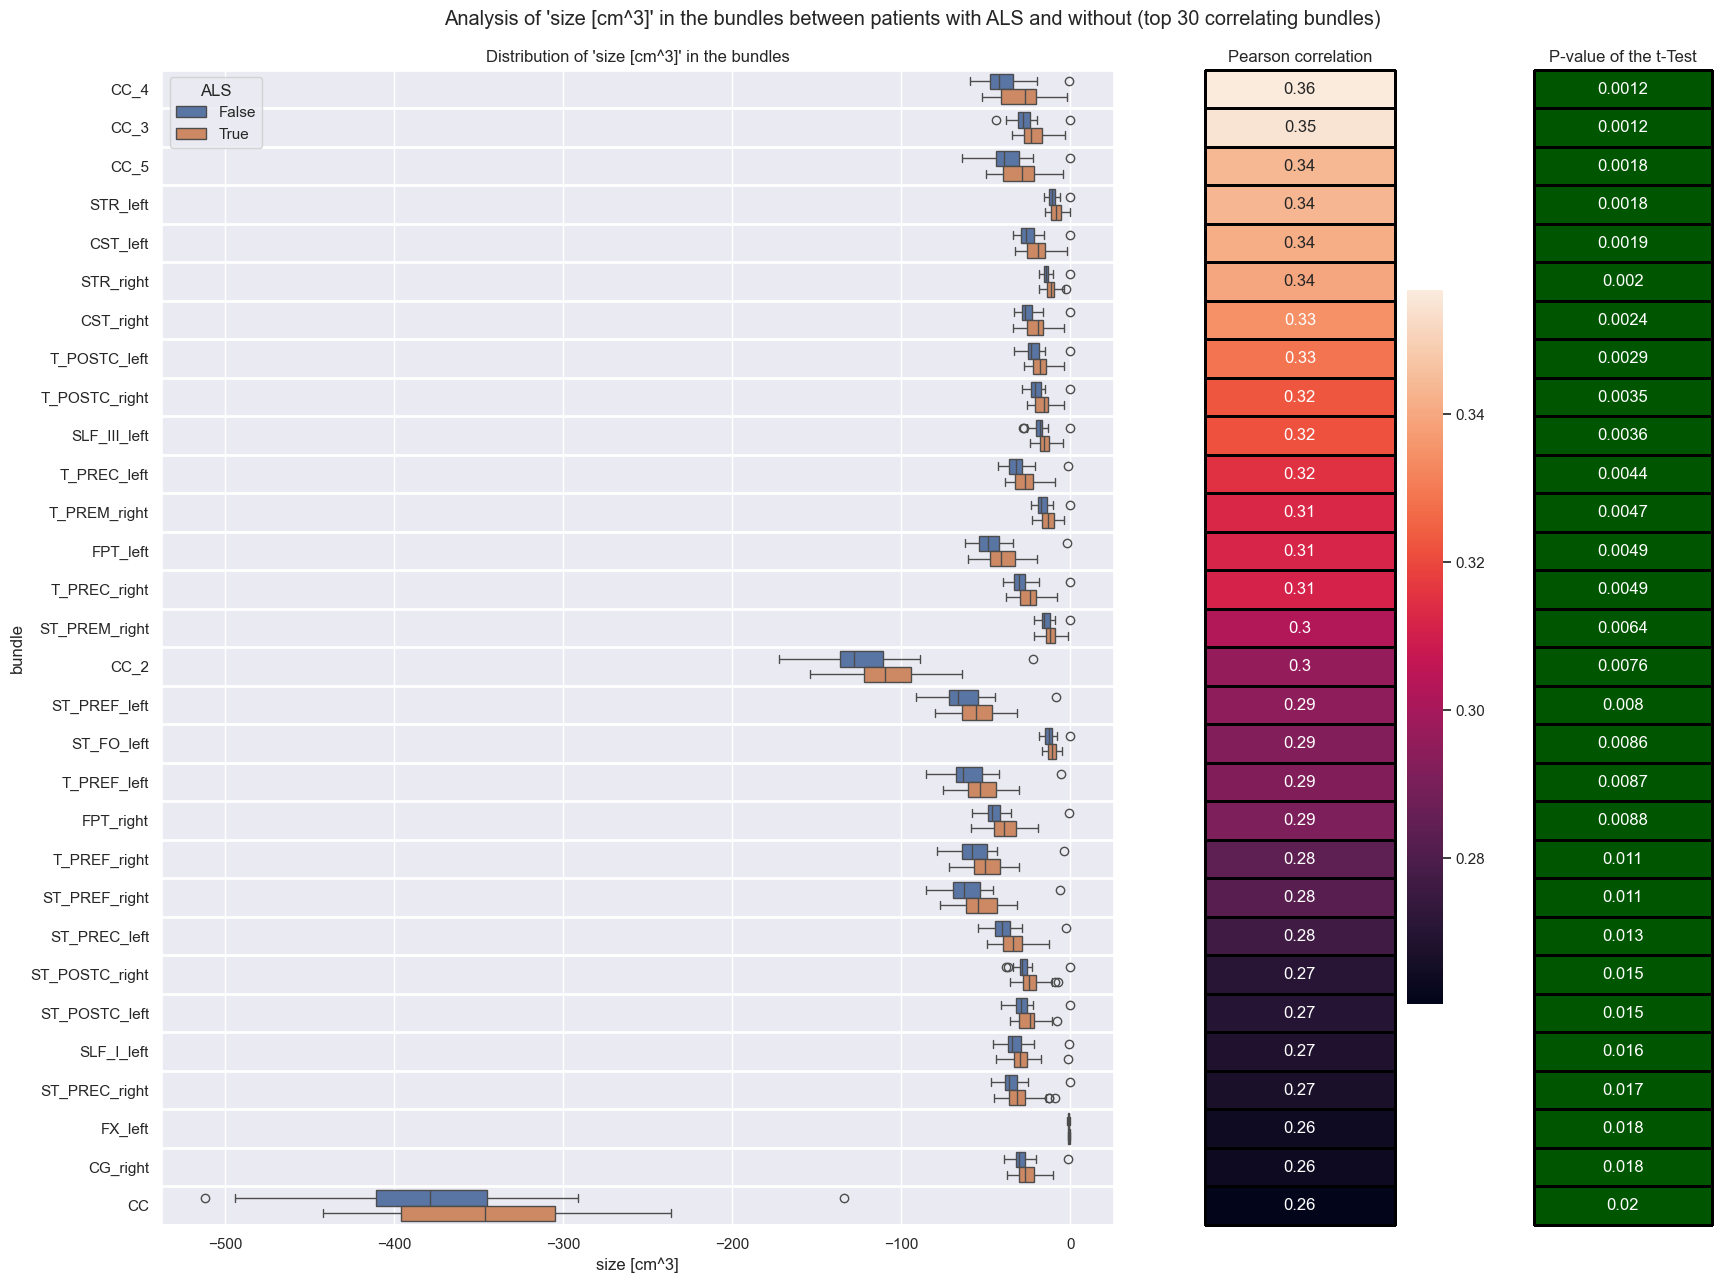

In [160]:
plot_metric(
    data=data, 
    metric="size [cm^3]",
    entity_name="bundle",
    class_name="ALS",
    top=30
)

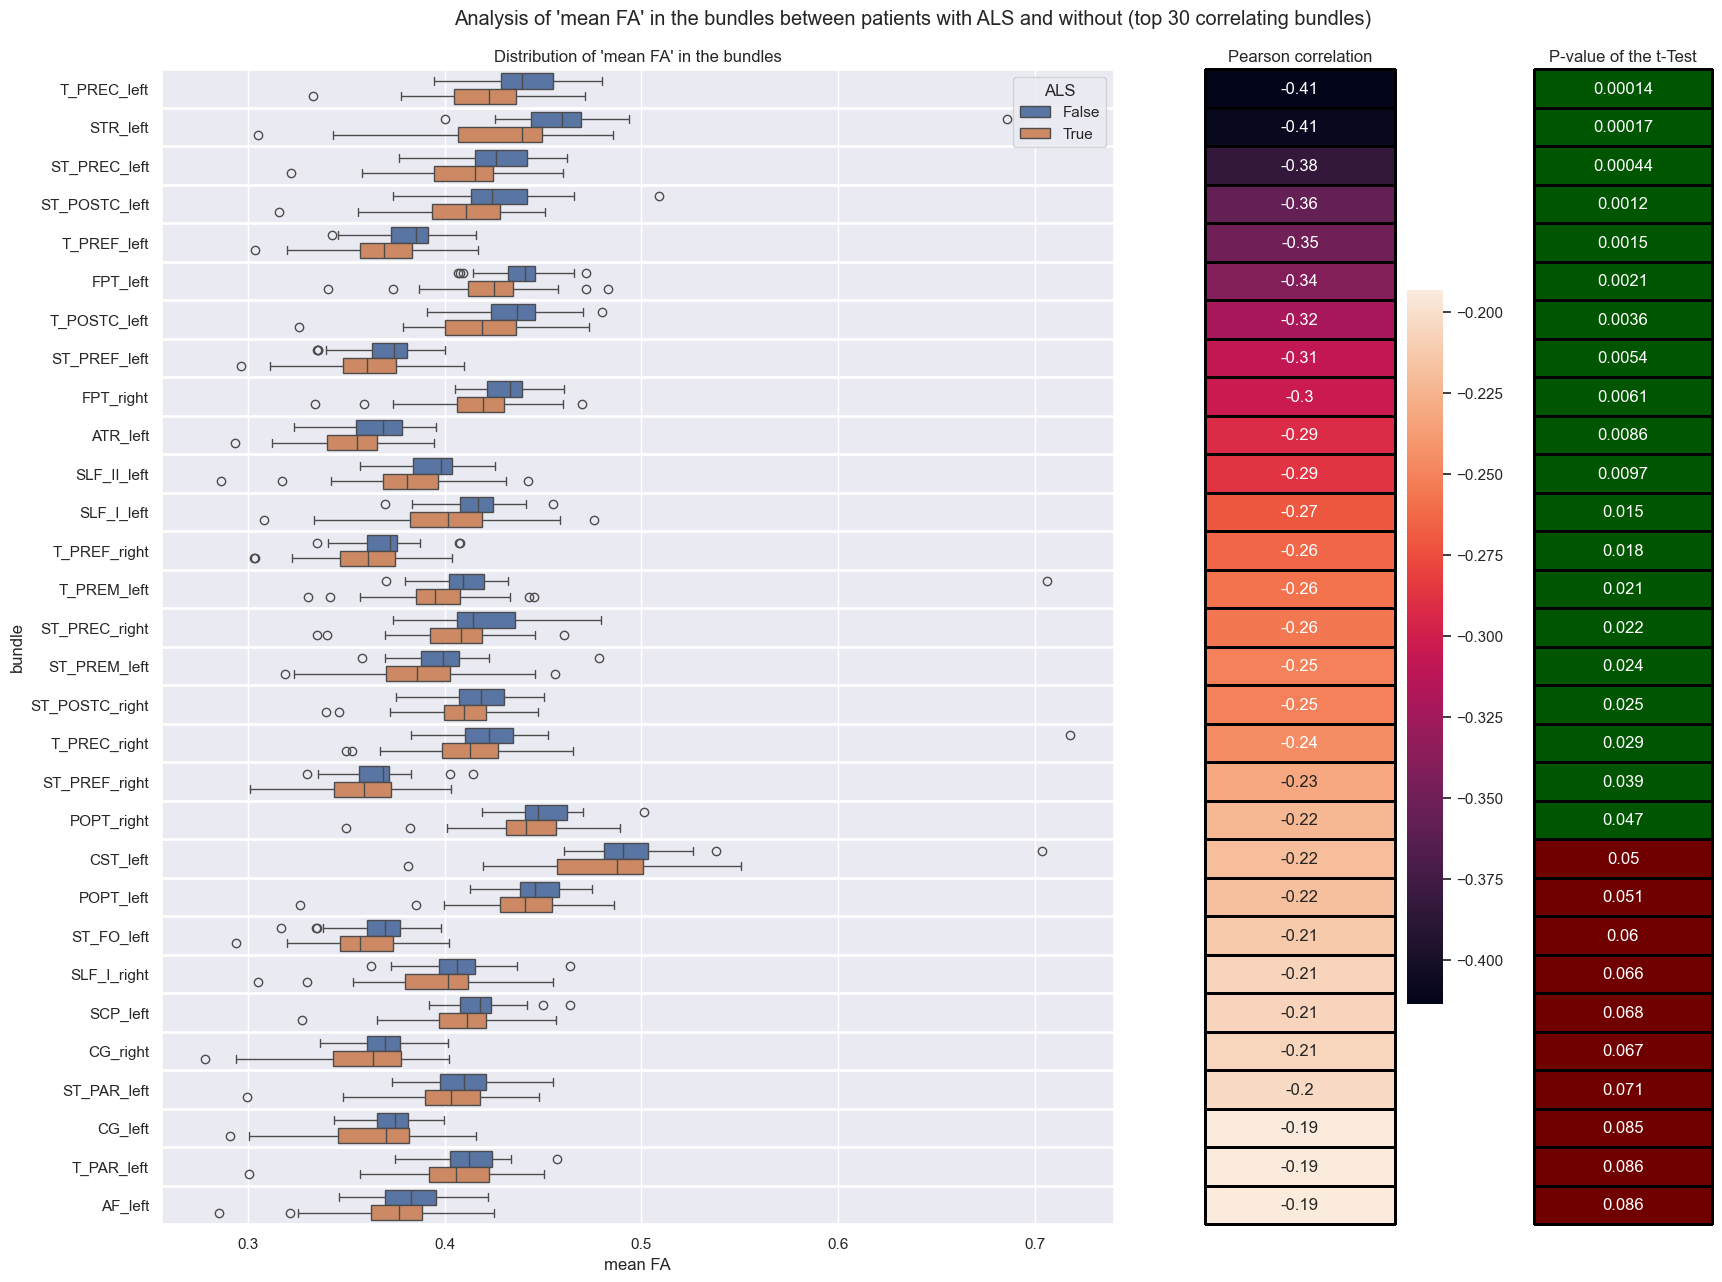

In [161]:
plot_metric(
    data=data, 
    metric="mean FA",
    entity_name="bundle",
    class_name="ALS",
    top=30
)

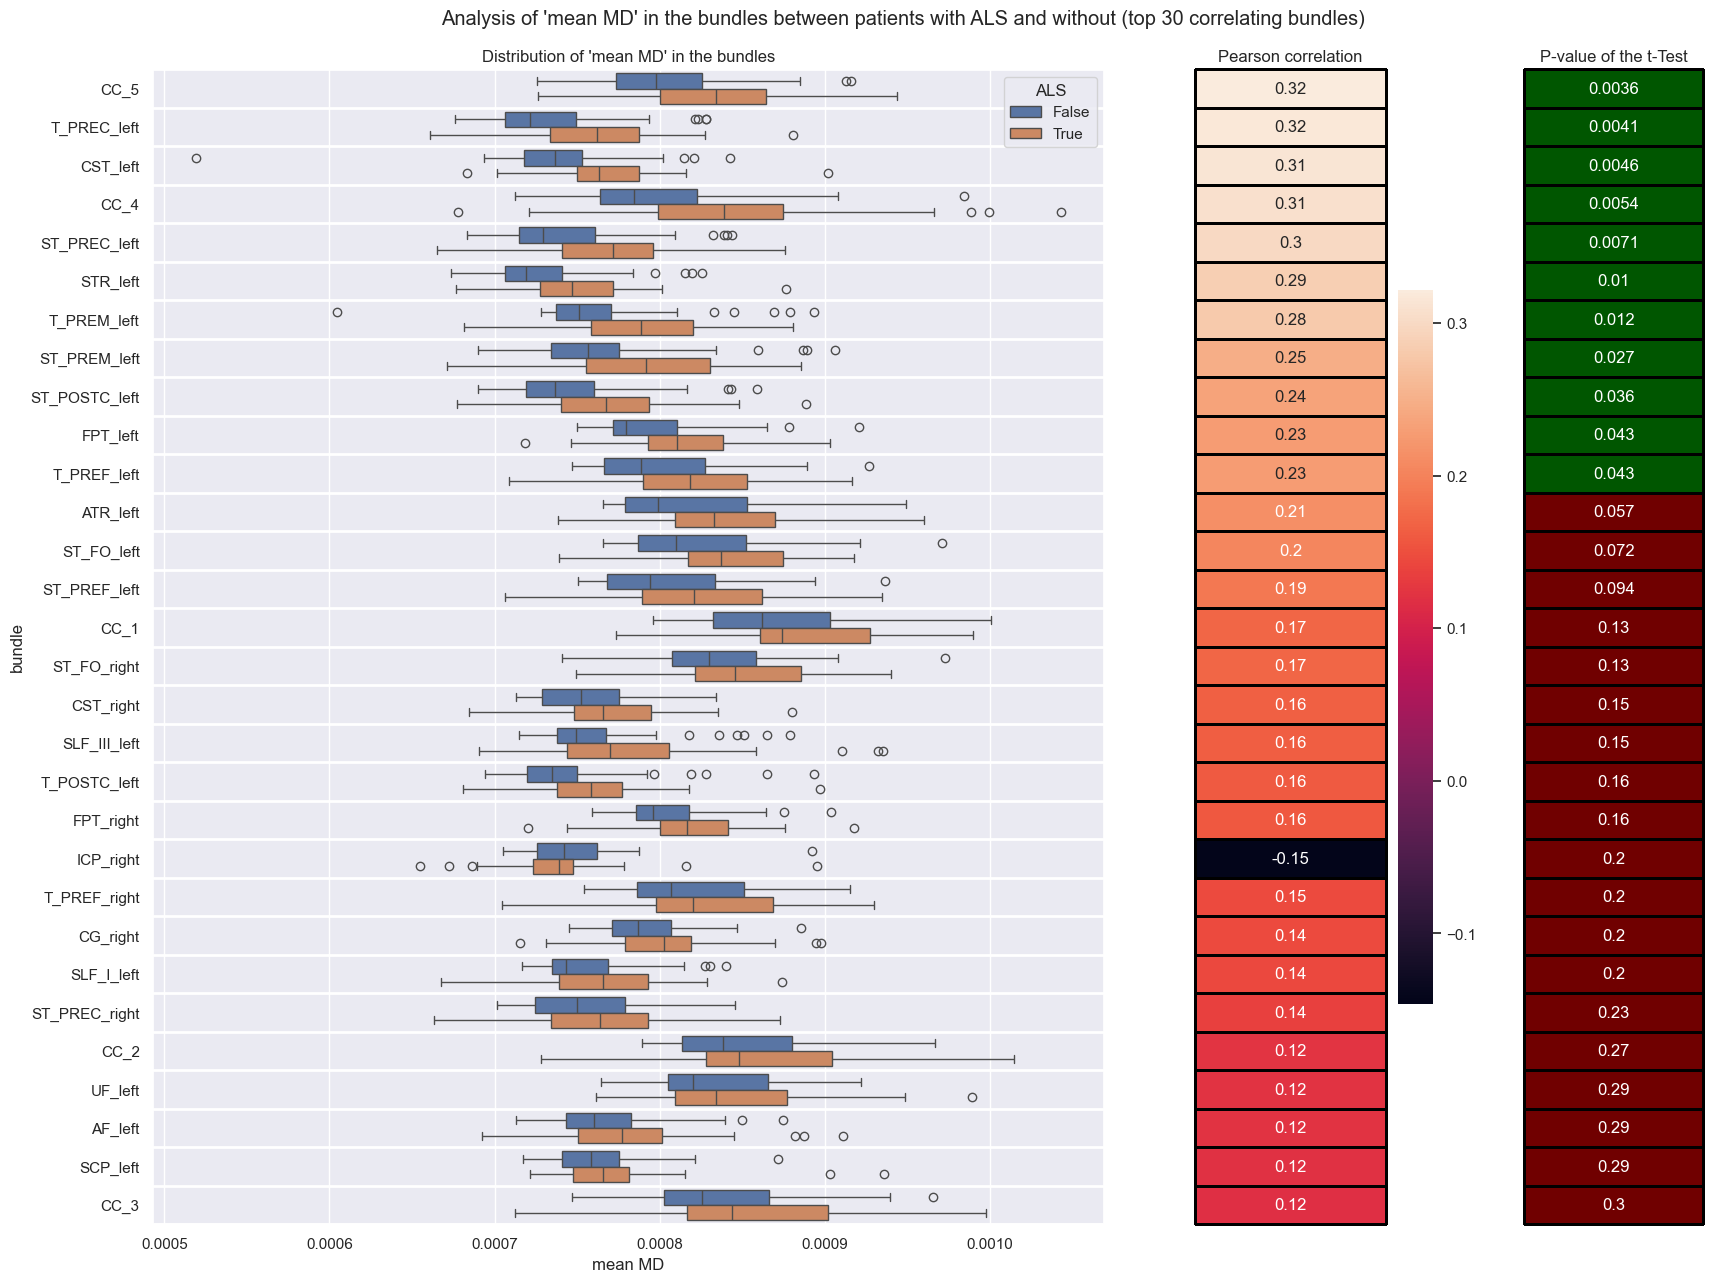

In [162]:
plot_metric(
    data=data, 
    metric="mean MD",
    entity_name="bundle",
    class_name="ALS",
    top=30
)

### 2. Endings

In [163]:
endings_data = load_data(
    root="../../Przygotowane_DTI_PR_MG_AK",
    true_dir="DTI_ALS_1_5T_TractSeg",
    false_dir="DTI_grupakontrolna_pod_ALS_1_5T_TractSeg/",
    filepath="endings_segmentations/endings_segmentations_volumes.csv"
)
endings_data = endings_data.rename(columns={"name": "ending", " cm^3": "size [cm^3]"})

characteristics_data = load_data(
    root="../../Przygotowane_DTI_PR_MG_AK",
    true_dir="DTI_ALS_1_5T_TractSeg",
    false_dir="DTI_grupakontrolna_pod_ALS_1_5T_TractSeg/",
    filepath="3d_characteristics/3d_characteristics_volumes.csv"
)
characteristics_data = characteristics_data.rename(columns={"name": "ending", " cm^3": "size [cm^3]"})

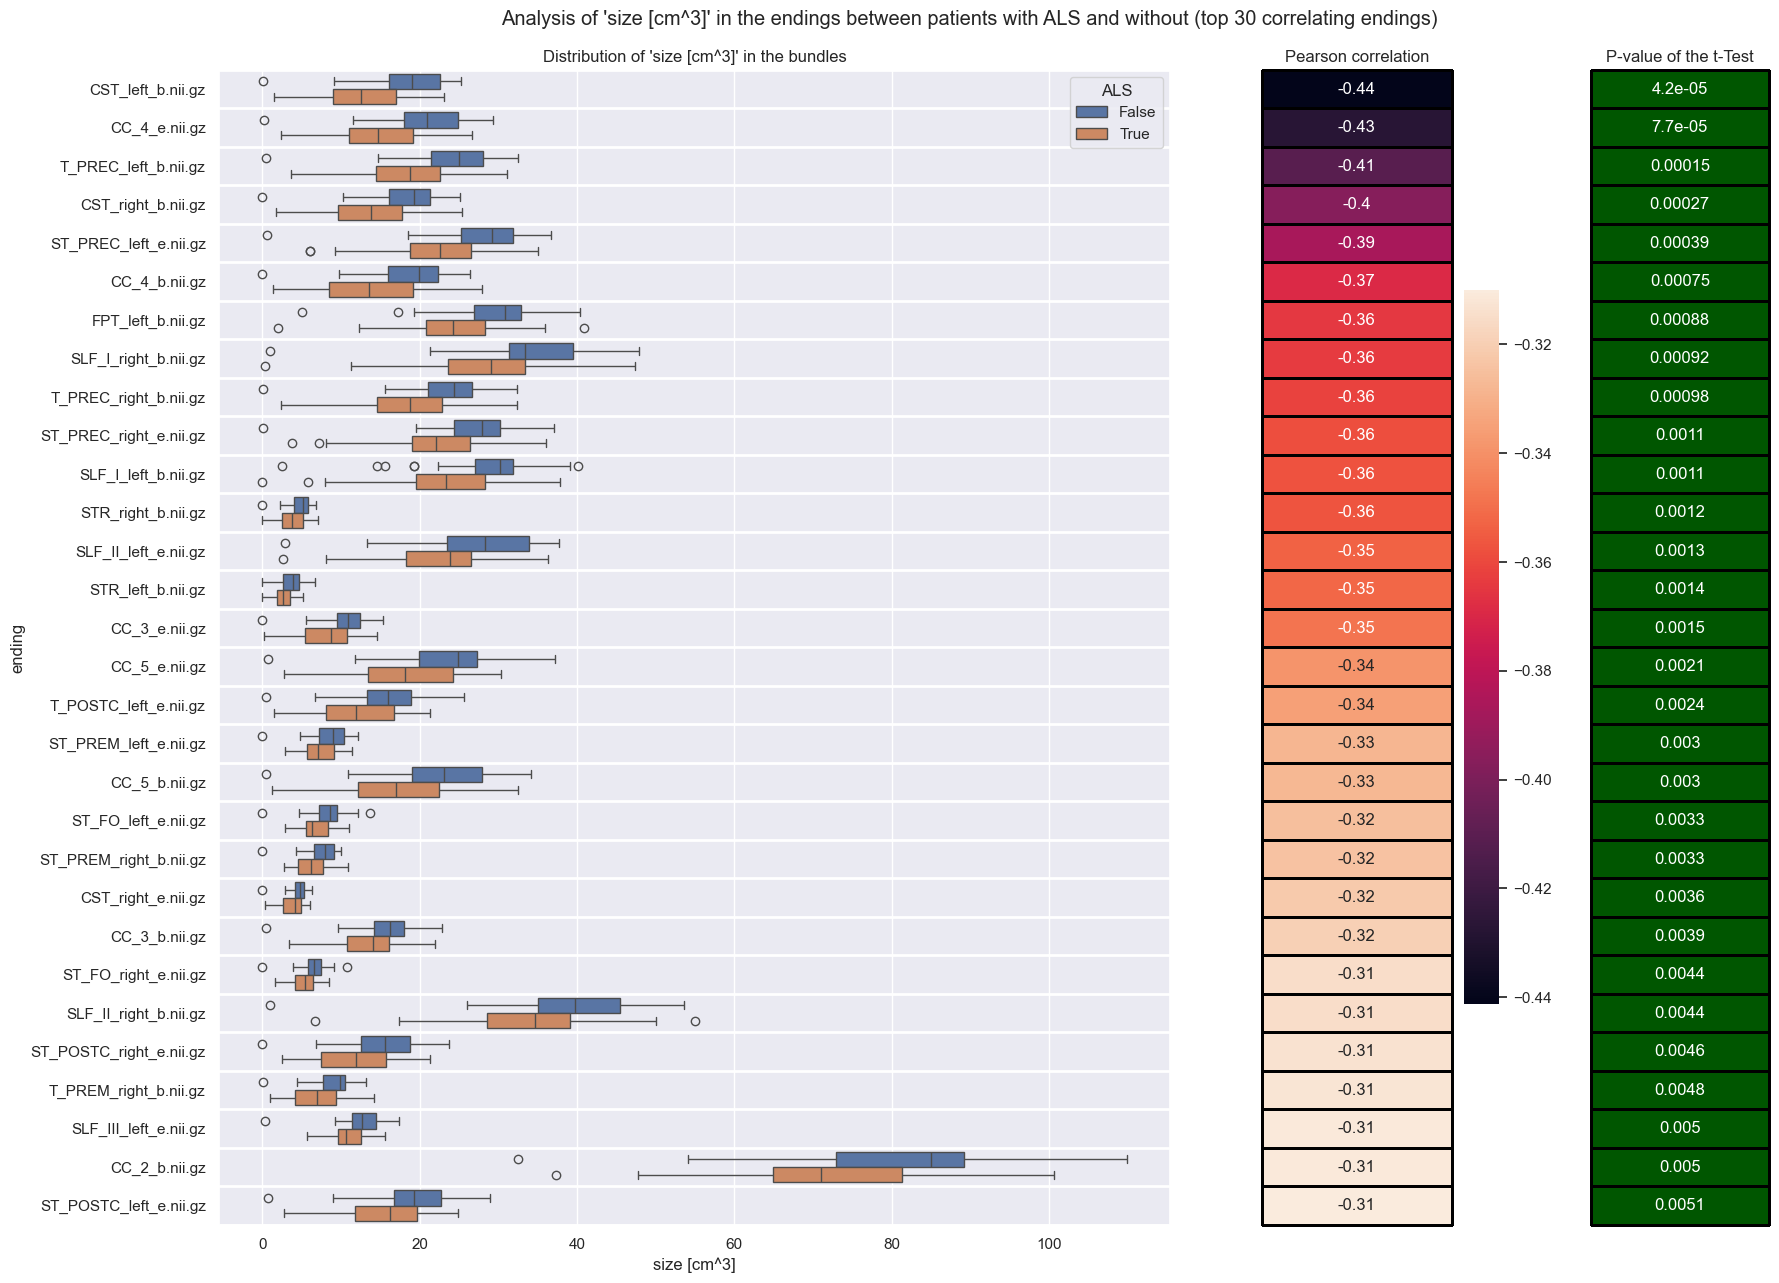

In [164]:
plot_metric(
    data=endings_data, 
    metric="size [cm^3]",
    entity_name="ending",
    class_name="ALS",
    top=30
)

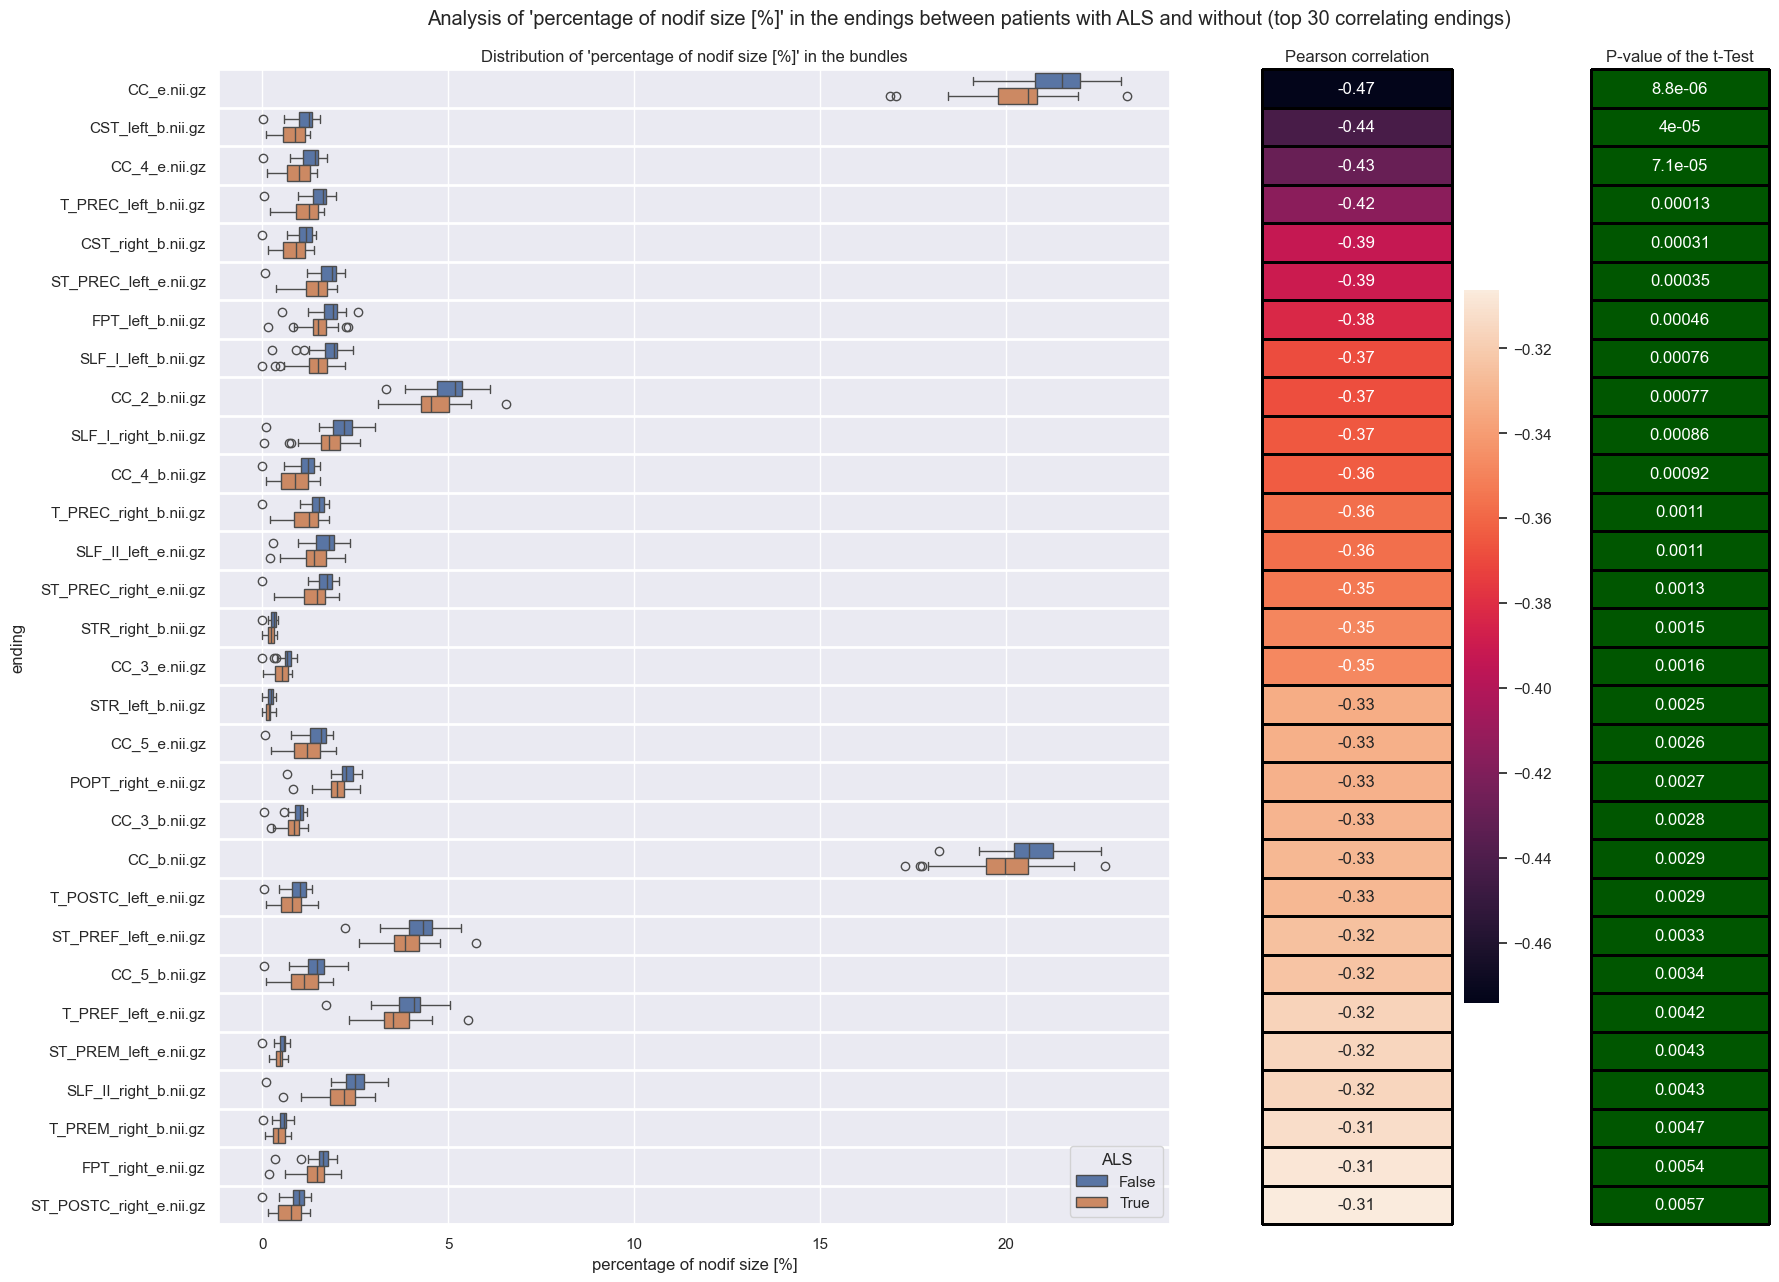

In [165]:
nodif_data = characteristics_data[characteristics_data["ending"] == "nodif_brain_mask.nii.gz"]
nodif_data = nodif_data[["size [cm^3]", "patient_id"]].rename(columns={"size [cm^3]": "nodif_size [cm^3]"})
nodif_data = pd.merge(endings_data, nodif_data, on="patient_id")
nodif_data["percentage of nodif size [%]"] = 100 * nodif_data["size [cm^3]"] / nodif_data["nodif_size [cm^3]"]

plot_metric(
    data=nodif_data, 
    metric="percentage of nodif size [%]",
    entity_name="ending",
    class_name="ALS",
    top=30
)

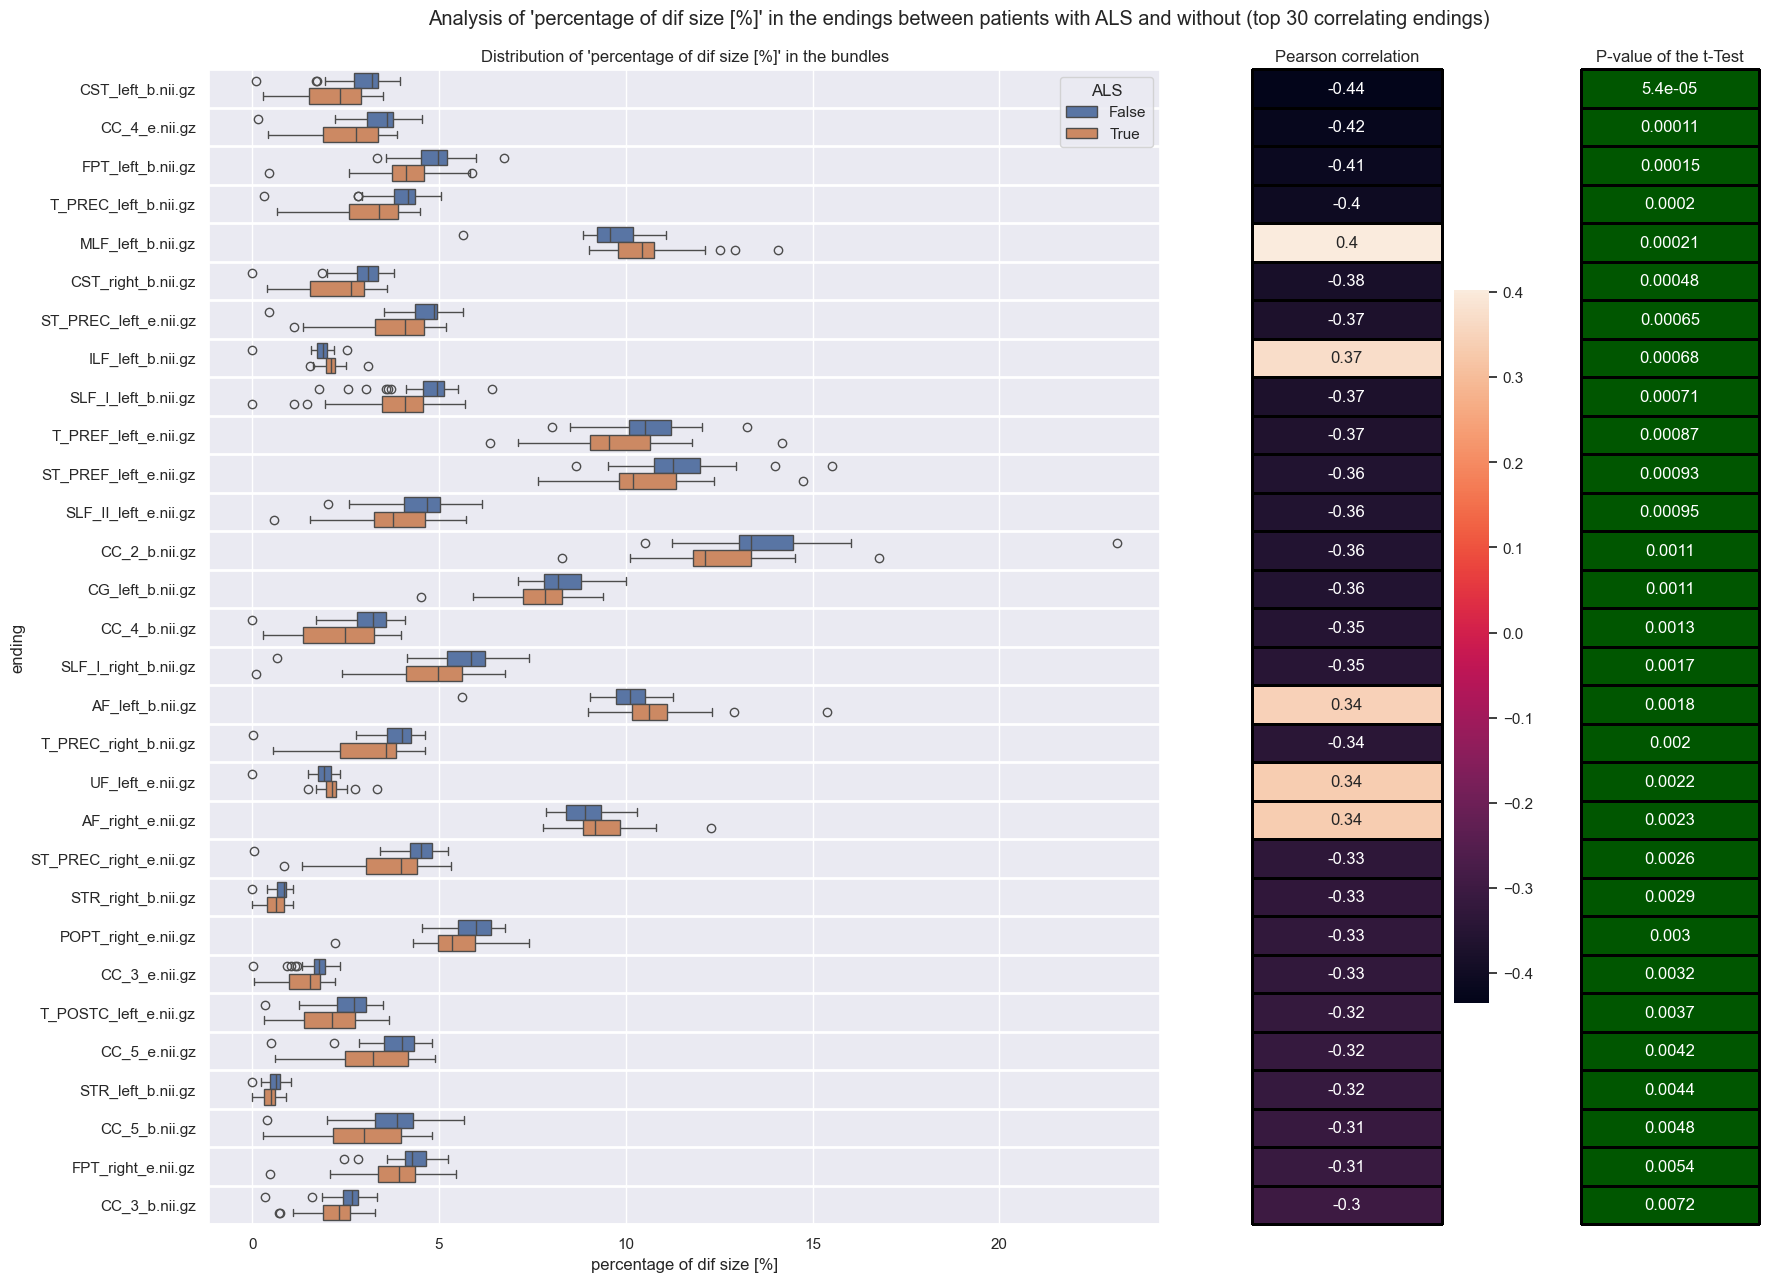

In [166]:
dif_data = characteristics_data[characteristics_data["ending"] == "dif_brain_mask.nii.gz"]
dif_data = dif_data[["size [cm^3]", "patient_id"]].rename(columns={"size [cm^3]": "dif_size [cm^3]"})
dif_data = pd.merge(endings_data, dif_data, on="patient_id")
dif_data["percentage of dif size [%]"] = 100 * dif_data["size [cm^3]"] / dif_data["dif_size [cm^3]"]

plot_metric(
    data=dif_data, 
    metric="percentage of dif size [%]",
    entity_name="ending",
    class_name="ALS",
    top=30
)